# This Program will predict Tesla Stock Price using TensorFlow

__Objectives:__

1. Collecting and Cleaning Tesla Stock Data
2. Using Tensorflow framework to train the model on Tesla Stock Price
3. Evaluating Tensorflow framework

## Collecting and Cleaning the Tesla Stock Data

To collect the data we will be using Yahoo finance to obtain Tesla Stock Data

In [ ]:
pip install yfinance

__Here we are importing the necessary libraries__

In [ ]:
import yfinance as yf
import pandas as pd

__Here we are setting the period to max to obtain as much historical data as possible__

In [ ]:
Tesla = yf.Ticker("TSLA") # creating a ticker object for Tesla
Tesla_share_price_data = Tesla.history(period="max")
Tesla_share_price_data.reset_index(inplace=True)

__Drop rows with any null values__

In [ ]:
Tesla_share_price_data.dropna(inplace = True)

__Get the last 5 rows__

In [ ]:
Tesla_share_price_data.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
3556,2024-08-15 00:00:00-04:00,205.020004,215.880005,204.820007,214.139999,89848500,0.0,0.0
3557,2024-08-16 00:00:00-04:00,211.149994,219.800003,210.800003,216.119995,88765100,0.0,0.0
3558,2024-08-19 00:00:00-04:00,217.070007,222.979996,214.089996,222.720001,76435200,0.0,0.0
3559,2024-08-20 00:00:00-04:00,224.880005,228.220001,219.559998,221.100006,74001200,0.0,0.0
3560,2024-08-21 00:00:00-04:00,222.669998,224.660004,218.860001,223.270004,70003100,0.0,0.0


In [ ]:
!pip install tensorflow

In [ ]:
pip install scikeras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 35.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


__Importing all the libraries needed__

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
import warnings

In [ ]:
warnings.filterwarnings('ignore', category=UserWarning)

__Visualising the current Tesla stock price__

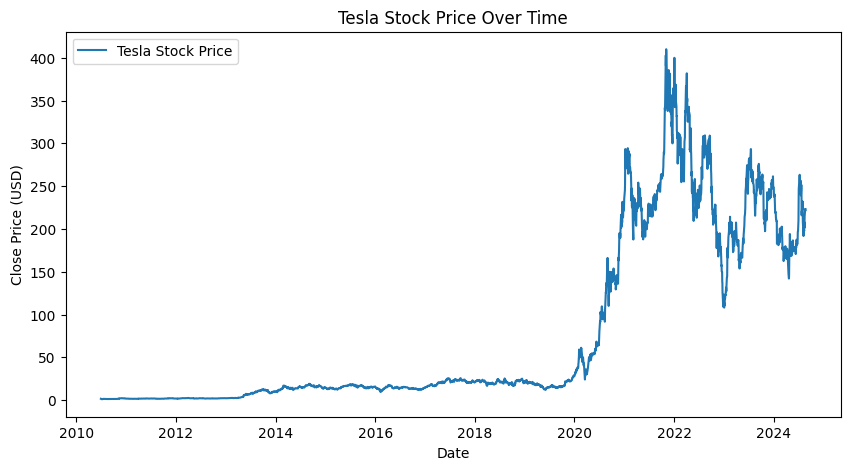

In [ ]:
# Create a copy of the DataFrame slice
Tesla_Stock_Data = Tesla_share_price_data[['Date', 'Close']].copy()

# Convert 'Date' to datetime
Tesla_Stock_Data['Date'] = pd.to_datetime(Tesla_Stock_Data['Date'])

# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(Tesla_Stock_Data['Date'], Tesla_Stock_Data['Close'], label='Tesla Stock Price')

# Adding title and labels
plt.title('Tesla Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()

# Display the plot
plt.show()

__Here we split the data into training and testing using a 80:20 ratio. 
We then normalise the data so that all the values are within a range between 0 and 1 that allows us to analyse and train the model easier. Since this is a time-series problem, we create a method that creates sequences for us. The create_sequences function gives us sequences of length 30 which are the input and the next data point is the target to predict.__

In [ ]:
# Step 1: Train-test split
train_data, test_data = train_test_split(Tesla_Stock_Data['Close'].values.reshape(-1, 1), test_size=0.2, shuffle=False)

scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

sequence_length = 30

print("Calling create_sequences function")
x_train, y_train = create_sequences(train_data_scaled, sequence_length)
x_test, y_test = create_sequences(test_data_scaled, sequence_length)

# Reshape for LSTM
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

Calling create_sequences function


## Using Tensorflow framework to train the model on Tesla Stock Price


__Here we are using a tensorflow framework for building and training the LSTM model.__

In [ ]:
def create_model(units=50, dropout_rate=0.2):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(units, return_sequences=False, input_shape=(x_train.shape[1], 1)))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

__Here we use GridSearchCV to find the best hyperparameters for our model__

In [ ]:
model = KerasRegressor(model=create_model, verbose=0)

# Define the parameter grid
param_grid = {
    'model__units': [50, 100, 150],
    'batch_size': [16, 32, 64],
    'epochs': [10, 20, 30]
}

# Set up GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

In [ ]:
print("fitting the training data using the grid object")
grid_result = grid.fit(x_train, y_train)

# Print the best results
print(f"Best Score: {-grid_result.best_score_} using {grid_result.best_params_}")

# Retrieve the best model
best_model = grid_result.best_estimator_

# Predict on the test set
predicted_stock_price = best_model.predict(x_test)

# Inverse transform to get actual prices
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
actual_stock_price = scaler.inverse_transform(y_test.reshape(-1, 1))

fitting the training data using the grid object


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Score: 0.00014678279083688549 using {'batch_size': 32, 'epochs': 30, 'model__units': 100}


__Plotting the actual stock price vs the predicted stock price__

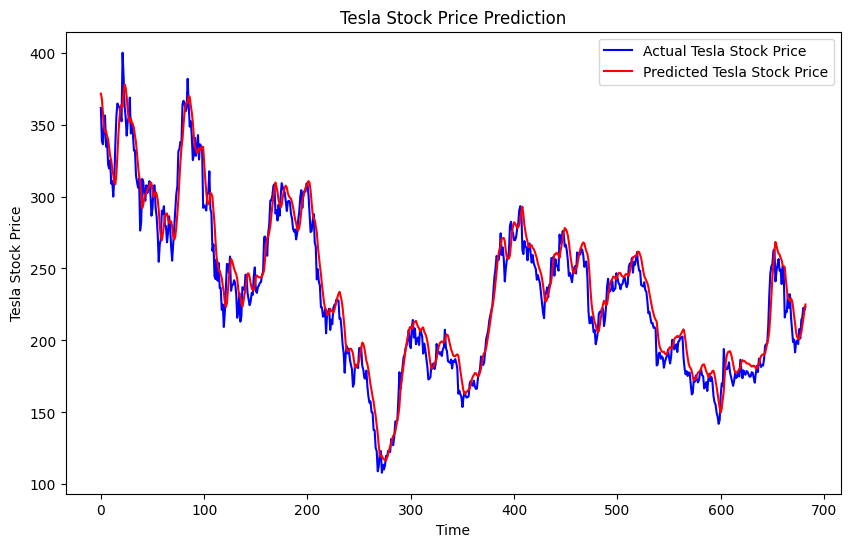

In [ ]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(actual_stock_price, color='blue', label='Actual Tesla Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.show()

## Evaluating TensorFlow Framework

__We are using the root mean square error as our evaluation metric.__

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_stock_price, predicted_stock_price))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 12.663416892784678
